In [34]:
from collections import Counter
from typing import Self

from common import SiteBasis

import cvxpy as cp
import numpy as np
from scipy.sparse import csr_array
import scipy as sp
from sympy.matrices import Matrix
import matplotlib.pyplot as plt
from bitarray import bitarray
from bitarray.util import count_and

In [35]:
# An efficient implementation of Pauli string operations (arXiV:2405.19287)
# z is bits [0, 2, 4, ...], x is bits [1, 3, 5, ...]

class PauliString:
    CODEC = {'I': bitarray('00'),
             'Z': bitarray('10'),
             'X': bitarray('01'),
             'Y': bitarray('11'),}
    def __init__(self, label: str | Self = None, bits: bitarray = None):
        self.bits = None
        if not ((label is None) ^ (bits is None)):
            raise ValueError("exactly one of label or bits must be provided")
        if bits is None:
            if isinstance(label, str):
                self.bits = bitarray()
                self.bits.encode(self.CODEC, label)
            elif isinstance(label, PauliString):
                self.bits = label.bits.copy()
            else:
                raise TypeError(f"Unsupported type {type(label)}")
        else:
            if isinstance(bits, bitarray):
                self.bits = bits.copy()
            else:
                raise TypeError(f"Unsupported type {type(bits)}")
    
    def __hash__(self):
        return hash(str(self.bits))

    def __repr__(self):
        return ''.join(self.bits.decode(self.CODEC))
    
    def __eq__(self, other):
        """Equality of two PauliStrings."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return self.bits == other.bits

    def __mul__(self, other: Self):
        """Multiply two PauliStrings."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return self.multiply(other)

    def __or__(self, other: Self):
        """Commutator of two PauliStrings."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return self.multiply(other) if not self.commutes_with(other) else None
    
    def __and__(self, other: Self):
        """Anticommutator of two PauliStrings."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return self.multiply(other) if self.commutes_with(other) else None
    
    def commutes_with(self, other: Self):
        """Check if two Pauli bitarrays commute."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return count_and(self.bits[::2], other.bits[1::2]) % 2 == count_and(self.bits[1::2], other.bits[::2]) % 2
    
    def phase(self, other: Self):
        """Find the phase of the product of two Pauli bitarrays."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return (-1j) ** ((2 * count_and(self.bits[1::2], other.bits[::2])
                          + count_and(self.bits[::2], self.bits[1::2])
                          + count_and(other.bits[::2], other.bits[1::2])
                          - count_and(self.bits[::2] ^ other.bits[::2], self.bits[1::2] ^ other.bits[1::2])) % 4)
    
    def multiply(self, other: Self):
        """Return the Pauli bitarray corresponding to the product of two Pauli bitarrays."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return PauliString(bits=self.bits ^ other.bits)

class PauliSum:
    # Consider implementing __iter__
    def __init__(self, labels_and_weights: dict[str, complex] | str | PauliString | Self):
        self.terms = None
        if isinstance(labels_and_weights, dict):
            self.terms = self.clean(Counter({PauliString(label): weight for label, weight in labels_and_weights.items()}))
        elif isinstance(labels_and_weights, str):
            self.terms = Counter({PauliString(labels_and_weights): 1.0})
        elif isinstance(labels_and_weights, PauliString):
            self.terms = Counter({PauliString(bits=labels_and_weights.bits): 1.0})
        elif isinstance(labels_and_weights, PauliSum):
            self.terms = labels_and_weights.terms.copy()
        else:
            raise TypeError(f"Unsupported type {type(labels_and_weights)}")
    
    def __hash__(self):
        raise NotImplementedError
    
    def __eq__(self, other: Self):
        if not isinstance(other, PauliSum):
            raise TypeError("other is not a PauliSum")
        if self.terms.keys() != other.terms.keys():
            return False
        for pstr, weight in self.terms.items():
            if not np.isclose(other.terms[pstr], weight):
                return False
        return True
    
    def __repr__(self):
        if self.is_zero():
            return f'{0j:.2f}'
        return '; '.join(f'{weight:.2f}*{string}' for string, weight in self.terms.items())
    
    def __iadd__(self, other: Self):
        if not isinstance(other, PauliSum):
            raise TypeError("other is not a PauliSum")
        for pstr, weight in other.terms.items():
            self.terms[pstr] += weight
            if np.isclose(self.terms[pstr], 0):
                del self.terms[pstr]
        return self
    
    def __add__(self, other: Self):
        res = PauliSum(self)
        res += other
        return res

    def __imul__(self, other: complex):
        if not isinstance(other, complex):
            raise TypeError("other is not a complex")
        for pstr in self.terms:
            self.terms[pstr] *= other
        return self

    def __rmul__(self, other: complex):
        if not isinstance(other, complex):
            raise TypeError("other is not a complex")
        res = PauliSum(self)
        res *= other
        return res

    def __mul__(self, other: Self | complex):
        """Multiply two PauliSums."""
        if isinstance(other, PauliSum):
            res = Counter()
            for l1, w1 in self.terms.items():
                for l2, w2 in other.terms.items():
                    res[l1 * l2] += l1.phase(l2) * w1 * w2
            return PauliSum(res)
        elif isinstance(other, complex):
            res = PauliSum(self)
            res *= other
            return res
        raise TypeError(f"Unsupported type {type(other)}")

    def __or__(self, other: Self):
        """Commutator of two PauliSums."""
        if not isinstance(other, PauliSum):
            raise TypeError("other is not a PauliSum")
        res = Counter()
        for l1, w1 in self.terms.items():
            for l2, w2 in other.terms.items():
                if not l1.commutes_with(l2):
                    res[l1 * l2] += 2 * l1.phase(l2) * w1 * w2
        return PauliSum(res)

    def __and__(self, other: Self):
        """Anticommutator of two PauliSums."""
        if not isinstance(other, PauliSum):
            raise TypeError("other is not a PauliSum")
        res = Counter()
        for l1, w1 in self.terms.items():
            for l2, w2 in other.terms.items():
                if l1.commutes_with(l2):
                    res[l1 * l2] += 2 * l1.phase(l2) * w1 * w2
        return PauliSum(res)
    
    def is_zero(self):
        return not self.terms

    def clean(self, dirty_counter: Counter):
        """Remove zero terms."""
        return Counter({label: weight for label, weight in dirty_counter.items() if not np.isclose(weight, 0)})

<h2>Thermal Transverse Field Ising:</h2>

In [36]:
def schwinger_dyson(hamil: PauliSum, word1: str) -> PauliSum:
    return hamil | PauliSum(word1)

def normalization(basis: SiteBasis, L: int, B: cp.Variable) -> list[cp.Constraint]:
    return [B[basis.rank('I'*L)] == 1]

def beta_independent_constraints(basis: SiteBasis, B: cp.Variable, L: int, hamil: PauliSum) -> list[cp.Constraint]:
    constraints = []
    constraints.extend(normalization(basis, L, B))
    row_ind, col_ind, data = [], [], []
    n_rows = 0
    n_cols = B.shape[0]
    def add_terms(psum: PauliSum):
        nonlocal n_rows
        new_row = 0
        for pstr, weight in psum.terms.items():
            new_row = 1
            row_ind.append(n_rows)
            col_ind.append(basis.rank(str(pstr)))
            data.append(weight)
        n_rows += new_row
    for word in basis._ops:
        add_terms(schwinger_dyson(hamil, word))
    if len(col_ind) > 0:
        P = csr_array((data, (row_ind, col_ind)), shape=(n_rows, n_cols))
        constraints.append(P @ B == 0)
    return constraints

def kms(basis: SiteBasis, H: cp.Variable, hamil: PauliSum, beta: cp.Parameter, k: int):
    ops = basis._ops
    n = len(ops)
    row_inds = [[] for _ in range(n)]
    col_inds = [[] for _ in range(n)]
    datas = [[] for _ in range(n)]
    for i in range(n):
        for j in range(n):
            pi = PauliString(ops[i])
            pj = PauliString(ops[j])
            pstr = pi * pj
            idx = basis.rank(str(pstr))
            row_inds[idx].append(i)
            col_inds[idx].append(j)
            datas[idx].append(pi.phase(pj))
    A = cp.sum([csr_array((datas[i], (row_inds[i], col_inds[i])), shape=(n, n)) * H[i] for i in range(n)])
    row_inds = [[] for _ in range(n)]
    col_inds = [[] for _ in range(n)]
    datas = [[] for _ in range(n)]
    for i in range(n):
        for j in range(n):
            pi = PauliSum(ops[i])
            pj = PauliSum(ops[j])
            psum = pi * (hamil | pj)
            if psum.is_zero():
                continue
            # Now, we have a PauliSum of terms...and also some zero locations
            # Experiments suggest that the sparsity is not much
            # Now each non-zero location is some linear combination of Pauli strings
            # in the reduced basis...how to deal with this?
            # Well, now it is a linear matrix inequality...just write as F[i] * x[i]
            # These F[i] are sparse
            for pstr, weight in psum.terms.items():
                idx = basis.rank(str(pstr))
                row_inds[idx].append(i)
                col_inds[idx].append(j)
                datas[idx].append(weight)
    C = cp.sum([csr_array((datas[i], (row_inds[i], col_inds[i])), shape=(n, n)) * H[i] for i in range(n)])
    T = 2**(-k) * beta * C
    B = cp.conj(A)
    Zs = [B] + [cp.Variable((n,n),f'Z_{i}',hermitian=True) for i in range(1, k + 1)]
    constraints = []
    for i in range(k):
        constraints.append(cp.bmat([[Zs[i], Zs[i+1]],
                                    [Zs[i+1], A]]) >> 0)
    al, be, ga, de = -1, 5, 2, 4
    b = (be*de - ga) / (be - al)
    a = de - b
    constraints.append(cp.bmat([[Zs[k] + al*A + a*T, np.sqrt(a*b) * T],
                                [np.sqrt(a*b) * T, Zs[k] + be*A + b*T]]) >> 0)
    return constraints

In [37]:
def construct_hamil(L: int, h: float) -> PauliSum:
    hamil = Counter()
    for i in range(L):
        t1 = None
        if i<L-1:
            t1 = 'I'*i + 'XX' + 'I'*(L-i-2)
        else:
            t1 = 'X' + 'I'*(L-2) + 'X'
        t2 = 'I'*i+'Z'+'I'*(L-i-1)
        hamil[t1] = -1
        hamil[t2] = -h
    if L == 2:
        hamil = Counter({'IZ': -h, 'ZI': -h, 'XX': -1})
    return PauliSum(hamil)

def construct_problem(L: int, h: float, k: int):
    basis = SiteBasis(L)
    B = cp.Variable(basis.size())
    hamil = construct_hamil(L, h)
    beta = cp.Parameter(nonneg = True)
    constraints = []
    constraints.extend(beta_independent_constraints(basis, B, L, hamil))
    constraints.extend(kms(basis, B, hamil, beta, k))
    energy = -1 * L * B[basis.rank('XX'+'I'*(L-2))] - h * L * B[basis.rank('Z'+'I'*(L-1))]
    if L == 2:
        energy = -1 * B[basis.rank('XX')] - h * 2 * B[basis.rank('Z'+'I'*(L-1))]
    minprob = cp.Problem(cp.Minimize(energy), constraints)
    maxprob = cp.Problem(cp.Maximize(energy), constraints)
    return beta, minprob, maxprob

def solve_energy(betas, beta, minprob, maxprob):
    mins,maxs = np.zeros_like(betas), np.zeros_like(betas)
    for i, val in enumerate(betas):
        beta.value = val
        print(f'Solving for T={1/val}, i={i}:')
        E_min = minprob.solve(accept_unknown=True, verbose=True)
        E_max = minprob.solve(accept_unknown=True)
        print(f'\tE_min = {E_min}')
        print(f'\tE_max = {E_max}')
        mins[i], maxs[i] = E_min, E_max
    return mins, maxs

In [235]:
L, h, k = 2, 1, 3
beta, minprob, maxprob = construct_problem(L, h, k)

In [236]:
betas = 1/np.linspace(0.01, 4, num = 1)
mins, maxs = solve_energy(betas, beta, minprob, maxprob)

(CVXPY) Jun 21 01:13:31 AM: Your problem has 310 variables, 1609 constraints, and 1 parameters.
(CVXPY) Jun 21 01:13:31 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 21 01:13:31 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 21 01:13:31 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jun 21 01:13:31 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Jun 21 01:13:31 AM: Reduction chain: Complex2Real -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Jun 21 01:13:31 AM: Applying reduction Complex2Real
(CVXPY) Jun 21 01:13:31 AM: Applying reduction Dcp2Cone
(CVXPY) Jun 21 01:13:31 AM: Applying reduction CvxAttr2Constr
(CVXPY) Jun 21 01:13:31 AM: Applying reduction ConeMatrixStuffing
(CVXPY) Jun 21 01:13:31 AM: Applying reduction MOSEK


Solving for T=0.01, i=0:
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jun 21 01:13:31 AM: Finished problem compilation (took 3.201e-01 seconds).
(CVXPY) Jun 21 01:13:31 AM: (Subsequent compilations of this problem, using the same arguments, should take less time.)
(CVXPY) Jun 21 01:13:31 AM: Invoking solver MOSEK  to obtain a solution.
(CVXPY) Jun 21 01:13:31 AM: Problem
(CVXPY) Jun 21 01:13:31 AM:   Name                   :                 
(CVXPY) Jun 21 01:13:31 AM:   Objective sense        : maximize        
(CVXPY) Jun 21 01:13:31 AM:   Type                   : CONIC (conic optimization problem)
(CVXPY) Jun 21 01:13:31 AM:   Constraints            : 310             
(CVXPY) Jun 21 01:13:31 AM:   Affine conic cons.     : 0               
(CVXPY) Jun 21 01:13:31 AM:   Disjunctive cons.      : 0               
(CVXPY) Jun 21 01:13:31 AM:   Cones                  : 0               
(CVXPY) Jun 21 01:13:31 AM:   Scalar variables       : 17              
(CVXPY) Jun 21 01:13:31 AM:   Matrix variables       : 4 (scalarized: 3280)
(CVXPY) Jun 21 01:

-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
	E_min = -2.2360679766234597
	E_max = -2.2360679766234597


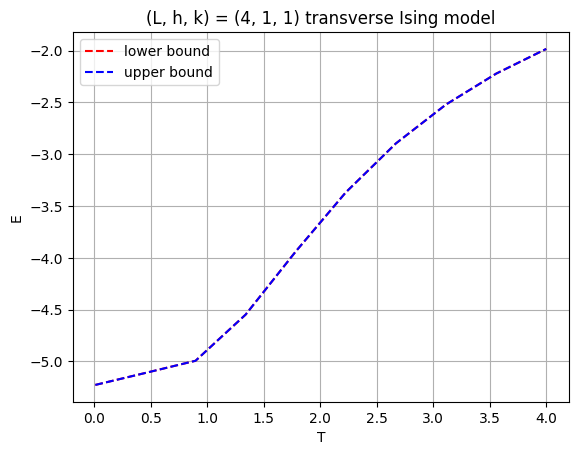

In [41]:
plt.fill_between(1/betas, mins, maxs, alpha = 0.5, zorder=2)
plt.plot(1/betas, mins,c ='red',linestyle='--',label='lower bound',zorder=3)
plt.plot(1/betas, maxs,c ='blue',linestyle='--',label='upper bound',zorder=3)
plt.xlabel('T')
plt.ylabel('E')
plt.title(f'(L, h, k) = ({L}, {h}, {k}) transverse Ising model')
plt.legend()
plt.grid(zorder=1)
plt.savefig(f'ising-{L}-{h}-{k}.png',bbox_inches='tight')
plt.show()

<h2>Manual basis reduction:</h2>

In [38]:
class BasisReduction():
    def __init__(self, A, b, basis):
        self._basis = basis
        self._A = A.copy()
        self._b = b.copy()
        # Row reduced echelon form of A | b system
        self._Arref, self._brref = Matrix(A).rref_rhs(Matrix(b))
        self._pivots = Matrix(A).rref()[1]
        self._free = sorted(list(set(range(A.shape[1])) - set(self._pivots))) # This is with the original numbering
        self._sz = len(self._free)
        self._reductions = [[PauliSum({}), 0.0] for _ in range(basis.size())]
        self._init_free() # Initialize mappings for free variables
        self._generate_reductions() # Initialize mappings for pivot variables

    def _init_free(self):
        for i, p in enumerate(self._free):
            self._reductions[p][0] = PauliSum(self._basis.unrank(i))
            self._reductions[p][1] = np.complex128(0.0)
    
    def _generate_reductions(self):
        crow = len(self._pivots) - 1
        for pcol in reversed(self._pivots):
            # Create mapping
            self._reductions[pcol][1] += np.double(self._brref[crow])
            for ccol in range(pcol + 1, self._A.shape[1]):
                if not np.isclose(self._Arref[crow, ccol], 0.0):
                    coeff = -complex(self._Arref[crow, ccol]) # minus sign to transfer to other side of equality
                    self._reductions[pcol][0] += coeff * self._reductions[ccol][0]
                    self._reductions[pcol][1] += coeff * self._reductions[ccol][1]
            # Update crow
            crow -= 1

    def size(self):
        return self._sz

    def reduce(self, elem: str):
        # Return a mapping of an element of the original basis
        # to a linear combination + constant offset of the new basis
        return self._reductions[self._basis.rank(elem)]
    
    def reduce_pauli_sum(self, op: PauliSum):
        red = [PauliSum({}), np.complex128(0.0)]
        for pstr, weight in op.terms.items():
            reduced = self.reduce(str(pstr))
            red[0] += weight * reduced[0]
            red[1] += weight * reduced[1]
        return red

In [43]:
def beta_independent_constraints(basis: SiteBasis, hamil: PauliSum) -> tuple[np.ndarray, np.ndarray]:
    # We handle normalization separately
    n_cols = basis.size() - 1
    A, b = [], []
    def add_terms(psum: PauliSum):
        if psum.is_zero():
            return
        A.append(np.zeros((1, n_cols), dtype=complex))
        identity_weight = 0.0
        for pstr, weight in psum.terms.items():
            if basis.rank(str(pstr)) == 0:
                identity_weight += weight
                continue
            A[-1][0, basis.rank(str(pstr))] += weight
        b.append(-identity_weight)
    for word in basis._ops:
        if basis.rank(word) == 0:
            continue
        add_terms(schwinger_dyson(hamil, word))
    A = np.vstack(A)
    b = np.vstack(b)
    return A, b

def kms(basis, redbas, H, hamil, beta, k):
    ops = basis._ops
    n = len(ops)
    constraints = []
    def get_A_term(i, j):
        coeff, word = product(ops[i], ops[j])
        rew, const = redbas.reduce(basis.rank(word))
        expression = coeff * const
        for p, c in rew.items():
            c2 = coeff * c
            # print(expression, 'coeff', coeff, 'c', c, 'c2', c2, 'p', p)
            expression = expression + c2 * H[p]
        return expression
    A = cp.bmat([[get_A_term(i, j) for j in range(n)] for i in range(n)])
    def get_C_term(i, j):
        expression = 0
        termsd = Counter()
        for coeff, w in hamil:
            terms = commutator(w, ops[j])
            for c, op in terms:
                if len(op) != len(w):
                    continue
                c2, op2 = product(ops[i], op)
                termsd[op2] += coeff * c * c2
        for op, coeff in termsd.items():
            if np.isclose(np.abs(coeff), 0):
                continue
            rew, const = redbas.reduce(basis.rank(op))
            subexpression = coeff * const
            for p, c in rew.items():
                subexpression = subexpression + coeff * c * H[p]
            # print(subexpression, 'coeff', coeff, 'exp', expression)
            # print(coeff * subexpression)
            expression = expression + subexpression
        return expression
    C = cp.bmat([[get_C_term(i, j) for j in range(n)] for i in range(n)])
    T = 2**(-k) * beta * C
    B = cp.conj(A)
    Zs = [B] + [cp.Variable((n,n),f'Z_{i}',hermitian=True) for i in range(1, k + 1)]
    for i in range(k):
        constraints.append(cp.bmat([[Zs[i], Zs[i+1]],
                                    [Zs[i+1], A]]) >> 0)
    al, be, ga, de = -1, 5, 2, 4
    b = (be*de - ga) / (be - al)
    a = de - b
    constraints.append(cp.bmat([[Zs[k] + al*A + a*T, np.sqrt(a*b) * T],
                                [np.sqrt(a*b) * T, Zs[k] + be*A + b*T]]) >> 0)
    return constraints

In [44]:
def construct_hamil(L: int, h: float) -> PauliSum:
    hamil = Counter()
    for i in range(L):
        t1 = None
        if i<L-1:
            t1 = 'I'*i + 'XX' + 'I'*(L-i-2)
        else:
            t1 = 'X' + 'I'*(L-2) + 'X'
        t2 = 'I'*i+'Z'+'I'*(L-i-1)
        hamil[t1] = -1
        hamil[t2] = -h
    if L == 2:
        hamil = Counter({'IZ': -h, 'ZI': -h, 'XX': -1})
    return PauliSum(hamil)

def construct_problem(L: int, h: float, k: int):
    basis = SiteBasis(L)
    B = cp.Variable(basis.size())
    hamil = construct_hamil(L, h)
    beta = cp.Parameter(nonneg = True)
    constraints = []
    constraints.extend(beta_independent_constraints(basis, B, L, hamil))
    constraints.extend(kms(basis, B, hamil, beta, k))
    energy = -1 * L * B[basis.rank('XX'+'I'*(L-2))] - h * L * B[basis.rank('Z'+'I'*(L-1))]
    if L == 2:
        energy = -1 * B[basis.rank('XX')] - h * 2 * B[basis.rank('Z'+'I'*(L-1))]
    minprob = cp.Problem(cp.Minimize(energy), constraints)
    maxprob = cp.Problem(cp.Maximize(energy), constraints)
    return beta, minprob, maxprob

def solve_energy(betas, beta, minprob, maxprob):
    mins,maxs = np.zeros_like(betas), np.zeros_like(betas)
    for i, val in enumerate(betas):
        beta.value = val
        print(f'Solving for T={1/val}, i={i}:')
        E_min = minprob.solve(accept_unknown=True, verbose=True)
        E_max = minprob.solve(accept_unknown=True)
        print(f'\tE_min = {E_min}')
        print(f'\tE_max = {E_max}')
        mins[i], maxs[i] = E_min, E_max
    return mins, maxs

In [242]:
L = 4
basis = SiteBasis(L, True, True)
hamil = construct_hamil(L, 1)
basis.size()

55

In [243]:
A, b = beta_independent_constraints(basis, hamil)
# redbas = BasisReduction(A, b, basis)

In [244]:
A_ns = sp.linalg.null_space(A)
a_rc = sp.linalg.null_space(np.hstack([np.imag(A_ns), np.real(A_ns)]))

In [246]:
print(A_ns.shape)
print(a_rc.shape)

(54, 12)
(24, 12)


In [245]:
Matrix(np.round(a_rc, 4))

Matrix([
[  0.088, -0.1066,  0.1126, -0.1311, -0.2824, -0.2866,  0.1654, -0.1429,  0.1848,  0.1829, -0.0211, -0.1922],
[-0.1232,  0.2026,  0.0943, -0.0476, -0.2055, -0.1406, -0.0172, -0.3507,  0.0007,  0.0514,  0.2653, -0.4927],
[ 0.0272, -0.2463,  0.3029,  0.2545,  0.1514,  -0.119, -0.2079,  0.1036, -0.0799,  0.0376, -0.1237, -0.0612],
[-0.1849,  -0.041,  0.0823,  0.2632,  0.0235, -0.1356, -0.4958,  0.1377, -0.2466,  0.1176,  0.0332,  0.0742],
[ 0.1244,  0.2632, -0.0574,  0.1869,  0.1763, -0.3086,   0.057,  -0.297, -0.1394, -0.1222,  0.3306, -0.0743],
[-0.1659, -0.0288, -0.1415, -0.3029,  0.2717,  0.1163, -0.0916, -0.1017, -0.1364,  -0.232,  0.1781,  0.2747],
[-0.1696, -0.3284,   0.399, -0.1076,  0.1719, -0.0926,  0.2441,  0.0327, -0.0531, -0.1297,   0.117, -0.0557],
[-0.0441, -0.0992, -0.0633,   -0.11,  0.0042,  0.0024, -0.2287, -0.1269,  0.0758, -0.0613,  0.1347, -0.2086],
[-0.1532, -0.3221, -0.1155, -0.0318,  0.0333,   0.191, -0.0933, -0.2875, -0.2563, -0.3188, -0.3142, -0.4054],
[

In [47]:
cnt_zero = 0
for op in basis._ops:
    reduced = redbas.reduce(op)
    if reduced[0].is_zero() and np.isclose(reduced[1], 0):
        cnt_zero += 1
print(basis.size()-cnt_zero)
print(basis.size())

7
20


In [26]:
cnt_zero = 0
for o1 in basis._ops:
    for o2 in basis._ops:
        p1 = PauliString(o1)
        p2 = PauliString(o2)
        p3 = p1 * p2
        reduced = redbas.reduce(str(p3))
        if reduced[0].is_zero() and np.isclose(reduced[1], 0):
            cnt_zero += 1
print('Size of matrix:', basis.size() ** 2)
print('Number of nonzero entries:', basis.size() ** 2 - cnt_zero)
print('Fraction of nonzero entries:', 1 - cnt_zero/basis.size() ** 2)

Size of matrix: 576
Number of nonzero entries: 288
Fraction of nonzero entries: 0.5


In [27]:
cnt_zero = 0
for o1 in basis._ops:
    for o2 in basis._ops:
        p1 = PauliSum(o1)
        p2 = PauliSum(o2)
        p3 = p1 * (hamil | p2)
        reduced = redbas.reduce_pauli_sum(p3)
        if reduced[0].is_zero() and np.isclose(reduced[1], 0):
            cnt_zero += 1
print('Size of matrix:', basis.size() ** 2)
print('Number of nonzero entries:', basis.size() ** 2 - cnt_zero)
print('Fraction of nonzero entries:', 1 - cnt_zero/basis.size() ** 2)

Size of matrix: 576
Number of nonzero entries: 240
Fraction of nonzero entries: 0.41666666666666663


In [29]:
L, h, k = 3, 1, 3
beta, minprob, maxprob = construct_problem(L, h, k)

TypeError: unsupported operand type(s) for |: 'list' and 'PauliSum'

In [ ]:
betas = 1/np.linspace(0.01, 4, num = 20)
mins, maxs = solve_energy(betas, beta, minprob, maxprob)

Solving for T=0.01, i=0:


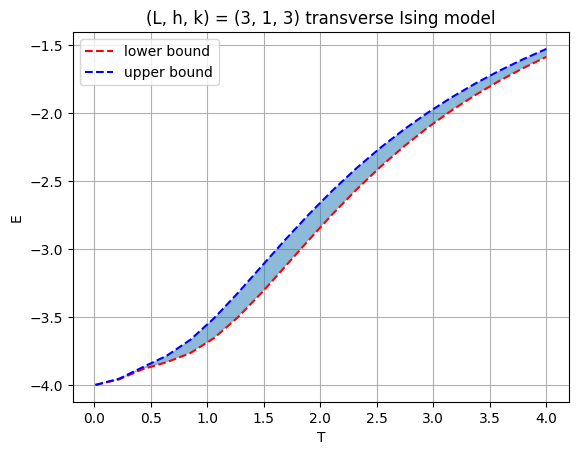

In [69]:
plt.fill_between(1/betas, mins, maxs, alpha = 0.5, zorder=2)
plt.plot(1/betas, mins,c ='red',linestyle='--',label='lower bound',zorder=3)
plt.plot(1/betas, maxs,c ='blue',linestyle='--',label='upper bound',zorder=3)
plt.xlabel('T')
plt.ylabel('E')
plt.title(f'(L, h, k) = ({L}, {h}, {k}) transverse Ising model')
plt.legend()
plt.grid(zorder=1)
plt.show()